# Table of Contents
- [1. Merge DataFrames](#1-merge-dataframes)
  - [1.1. Get ETF Prices](#1-1-get-etf-prices)
    - [1.1.1. Investment Universe below](#1-1-1-investment-universe-below)
  - [1.2. Macro Indicators](#1-2-macro-indicators)
- [2. 5 Factors](#2-5-factors)
  - [2.1. Technical – per-ETF basis](#2-1-technical-per-etf-basis)
  - [2.2. Regimes](#2-2-regimes)
    - [2.2.1. Merge all and research](#2-2-1-merge-all-and-research)
- [3. Linear Model](#3-linear-model)
- [4. ENet Model](#4-enet-model)
- [5. XGBRegressor](#5-xgbregressor)
- [6. Alpha Overlay with traditional 60/40 Portfolio](#6-alpha-overlay-with-traditional-6040-portfolio)
- [7. Plots](#7-plots)
  - [7.1. Alpha Model Portfolio Performance Plots](#7-1-alpha-model-portfolio-performance-plots)
- [8. Alpha Model Performance Attribution](#8-alpha-model-performance-attribution)
  - [8.1. Goldilocks Regime](#8-1-goldilocks-regime)
  - [8.2. Slow Growth Regime](#8-2-slow-growth-regime)
  - [8.3. Stagflation Regime](#8-3-stagflation-regime)
  - [8.4. Heating Up Regime](#8-4-heating-up-regime)


## <a id="1-merge-dataframes"></a> 1. Merge DataFrames

In [83]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.mstats import winsorize
import statsmodels.api as sm

import yfinance as yf

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # for progress tracking

import numpy as np
import pandas as pd
import datetime
import calendar

import os

import PyFolio2 as pyf

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <a id="1-1-get-etf-prices"></a> 1.1. Get ETF Prices

#### <a id="1-1-1-investment-universe-below"></a> 1.1.1. Investment Universe below


In [87]:
import sys, os
#sys.path.append(os.path.abspath(".."))  # only if notebook is inside /notebooks
from src import analytics as an
from src.data_loader import (
    load_etf_prices,
    load_fama_french_factors,
    load_volatility_indices,
    load_macro_indicators,
    merge_all_factors,
    get_etf_data
)

# Load each component
#etf_prices = load_etf_prices("data/raw/1d_etf_prices_06_Jun.csv")
tickers = ['AGG','BIL','DBC','EFA','GLD','HYG','MTUM','SPY','TIP','TLT','USMV','VLUE','VNQ']
price_data,dividends = get_etf_data(tickers,'2000-01-01','2025-06-30')
etf_prices =  (1+(price_data.pct_change().fillna(0))).cumprod()
etf_prices.ffill().dropna(inplace = True)


#tgt_index

etf_1mth_fwd_returns = etf_prices.pct_change(20).shift(-20).dropna()['2013':]
etf_1mth_returns = etf_prices.pct_change(20).dropna()['2013':]
tgt_index = etf_1mth_fwd_returns.index

raw_rets = etf_prices.pct_change().fillna(0)
raw_rets = raw_rets.reindex(index = tgt_index)
etf_1mth_returns = etf_1mth_returns.reindex(index= etf_1mth_fwd_returns.index)

[*********************100%***********************]  13 of 13 completed


In [88]:
etf_1mth_fwd_returns.shape


(3119, 13)

### <a id="1-2-macro-indicators"></a> 1.2. Macro Indicators


In [90]:
def last_day_of_month(date_str):
    date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    last_day = calendar.monthrange(date.year, date.month)[1]  # Get last day of month
    return date.replace(day=last_day)

In [91]:
#Import and clean macro indicators
filepath = os.path.join(os.getcwd(),r"data/raw")
median_cpi = 'MedianCPI.csv'
unemployment = 'UNRATE.csv'
ir = 'ir10y.csv'

macro_df = []
for file in [median_cpi,unemployment,ir]:
    f = os.path.join(filepath,file)
    macro_df.append(pd.read_csv(f,index_col = 0).sort_index())
macro_df = pd.concat(macro_df,axis = 1).sort_index()
macro_df.index = [last_day_of_month(dt) for dt in macro_df.index]
macro_df.index.names = ['Date']
macro_df[['UNRATE','REAINTRATREARAT10Y']] = macro_df[['UNRATE','REAINTRATREARAT10Y']].diff()
macro_df = macro_df.fillna(0).dropna()#.shift()
macro_df = macro_df['2013':].shift().fillna(0)

## <a id="2-5-factors"></a> 2. 5 Factors


In [93]:
f = os.path.join(filepath,'fffactors.csv')
ff_factors = pd.read_csv(f,index_col = 0)
ff_factors.index = [datetime.datetime.strptime(str(dt),"%Y%m%d") for dt in ff_factors.index]
ff_factors_monthly = ff_factors.rolling(30).sum()#.shift(-30)
#ff_factors.plot()

In [94]:
ff_factors_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-02,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-03,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-05,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-04-24,-1.08,-2.40,1.90,-1.27,-2.81,0.497
2025-04-25,1.05,-2.21,-0.67,-1.34,-3.67,0.498
2025-04-28,-1.08,-2.10,-0.61,-0.66,-3.93,0.499
2025-04-29,-1.22,-2.50,-0.79,-0.44,-4.12,0.500


### <a id="2-1-technical-per-etf-basis"></a> 2.1. Technical – per-ETF basis


In [102]:
idio_features = {}
for col in raw_rets.columns:
    temp = an.calculate_metrics(raw_rets[col]).fillna(0)#.corrwith(etf_1mth_fwd_returns[col])
    idio_features[col] = temp

### <a id="2-2-regimes"></a> 2.2. Regimes


In [105]:
regime = pd.read_csv('pred_regimes.csv',index_col = 0)
regime = regime[['PredLabel']]
regime = pd.get_dummies(regime,columns = ['PredLabel']).astype(float)
regime.index = [datetime.datetime.strptime(dt,"%Y-%m-%d") for dt in regime.index]
regime = regime.reindex(index = etf_1mth_fwd_returns.index).ffill().fillna(0)
regime#.tail(60)

,PredLabel_Goldilocks,PredLabel_Heating Up,PredLabel_Slow Growth,PredLabel_Stagflation
Date,,,,
2013-01-02,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0
2013-01-07,0.0,0.0,0.0,0.0
2013-01-08,0.0,0.0,0.0,0.0
...,...,...,...,...
2025-05-20,1.0,0.0,0.0,0.0
2025-05-21,1.0,0.0,0.0,0.0
2025-05-22,1.0,0.0,0.0,0.0


#### <a id="2-2-1-merge-all-and-research"></a> 2.2.1. Merge all and research


In [108]:
ff_factors_monthly = ff_factors_monthly.reindex(index = tgt_index).ffill()
macro_df = macro_df.reindex(index = tgt_index).ffill().fillna(0)
merged = pd.concat([ff_factors_monthly,macro_df,regime],axis = 1).ffill().fillna(0)
merged = sm.add_constant(merged)

## <a id="3-linear-model"></a> 3. Linear Model



lookback_wdw = 250*5
final_pred = an.rolling_lr(etf_1mth_fwd_returns,merged,idio_features,lookback_wdw,model = 'linear')
final_pred.to_excel('linear_model_returns_prediction.xlsx')

In [113]:
wdw = 5*250
final_pred = pd.read_excel('linear_model_returns_prediction.xlsx',index_col = 0)#.shift()

# Safely align both DataFrames by their common index
common_index = etf_1mth_fwd_returns.index.intersection(final_pred.index)
etf_aligned_a = etf_1mth_fwd_returns.loc[common_index]
linear_aligned = final_pred.loc[common_index]

n = etf_aligned_a.shape[1]
wts = [[1/n]*n]
for i in range(1,len(etf_aligned_a)):
    train = etf_1mth_returns.iloc[max(0,i-wdw):i]
    optimize = pyf.pyOpt(train)
    ret_pred = linear_aligned.iloc[i]
    try:
        w = optimize.get_max_sharpe_wts(mu = ret_pred,min_w = 0,max_w = 0.3)
    except:
        w = [1/n]*n
    wts.append(w)
wts = pd.DataFrame(wts)
wts.index = etf_aligned_a.index
wts.columns = etf_aligned_a.columns 
# Clip negatives and very small values
threshold = 1e-4
wts = wts.clip(lower=0)
wts[wts < threshold] = 0
#normalize weights to one
wts_linear = wts.div(wts.sum(axis=1), axis=0).fillna(0)

wts_monthly_rebal_linear = wts_linear.resample('M').last().reindex(index =wts.index ).ffill()

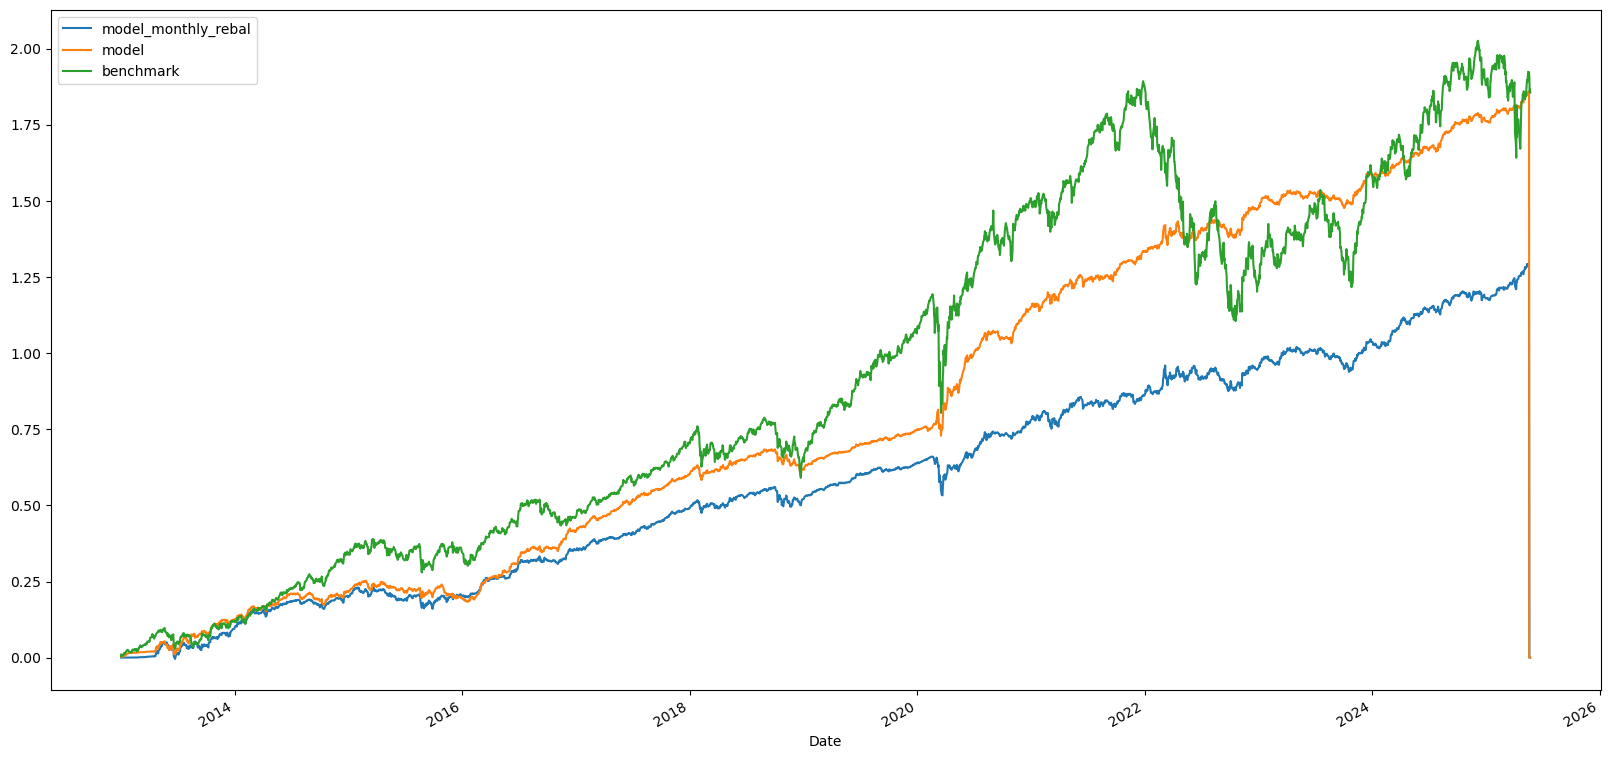

In [114]:
model_monthly_rebal_linear = ((1+(wts_monthly_rebal_linear*raw_rets)).cumprod()-1).sum(axis = 1).iloc[:-1]
model_monthly_rebal_linear.iloc[:-1].plot(label = 'model_monthly_rebal',figsize = (20,10))

# ((1+(wts_monthly_rebal*raw_rets)).cumprod()-1).sum(axis = 1).iloc[:-1].plot(label = 'model_monthly_rebal',figsize = (20,10))
# ((1+(wts*raw_rets)).cumprod()-1).sum(axis = 1).plot(label = 'model',figsize = (20,10))
model_linear = ((1+(wts_linear*raw_rets)).cumprod()-1).sum(axis = 1).iloc[:-1]
# ((1+(wts*raw_rets)).cumprod()-1).sum(axis = 1).iloc[:-1].plot(label = 'model',figsize = (20,10))
model_linear.plot(label = 'model',figsize = (20,10))

benchmark_linear = ((1+(0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])).cumprod()-1).iloc[:-1]
# ((1+(0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])).cumprod()-1).plot(label = 'benchmark')
benchmark_linear.plot(label = 'benchmark')
plt.legend()

## <a id="4-enet-model"></a> 4. ENet Model


In [ ]:

lookback_wdw = 250*5
final_pred = an.rolling_lr(etf_1mth_fwd_returns,merged,idio_features,lookback_wdw,model ='eNet')
final_pred.to_excel('enet_model_returns_prediction.xlsx')

AGG


In [199]:
#an.rolling_lr(etf_1mth_fwd_returns,merged,lookback_wdw,model = 'eNet')
wdw = 5*250
n = etf_1mth_fwd_returns.shape[1]
final_pred = pd.read_excel('enet_model_returns_prediction.xlsx',index_col = 0)
wts = [[1/n]*n]
for i in range(1,len(etf_1mth_fwd_returns)):
    train = etf_1mth_returns.iloc[max(0,i-wdw):i]
    optimize = pyf.pyOpt(train)
    ret_pred = final_pred.iloc[i]
    try:
        w = optimize.get_max_sharpe_wts(mu = ret_pred,min_w = 0,max_w = 0.25)
    except:
        w = [1/n]*n
    wts.append(w)
wts = pd.DataFrame(wts)
wts.index = etf_1mth_fwd_returns.index
wts.columns = etf_1mth_fwd_returns.columns   
# Clip negatives and very small values
threshold = 1e-4
wts = wts.clip(lower=0)
wts[wts < threshold] = 0
#normalize weights to one
wts_enet = wts.div(wts.sum(axis=1), axis=0).fillna(0)
wts_monthly_rebal_enet = wts_enet.resample("M").last().reindex(index = wts.index).ffill().bfill() 

In [ ]:
((1+(wts_monthly_rebal_enet*raw_rets)).cumprod()-1).sum(axis = 1).plot(label = 'model_monthly_rebal',figsize = (20,10))

model_enet = ((1+(wts.rolling(5).mean()*raw_rets)).cumprod()-1).sum(axis = 1)
model_enet.plot(label = 'model',figsize = (20,10))
benchmark_enet = ((1+(0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])).cumprod()-1)
benchmark_enet.plot(label = 'benchmark')
plt.legend()

## <a id="5-xgbregressor"></a> 5. XGBRegressor


In [ ]:

lookback_wdw = 250*5
#final_pred = an.rolling_lr(etf_1mth_fwd_returns,merged,idio_features,lookback_wdw,model ='xgb')
#final_pred.to_excel('xgb_model_returns_prediction.xlsx')

In [ ]:

xgb_pred = pd.read_excel('xgb_model_returns_prediction.xlsx',index_col = 0)

# Safely align both DataFrames by their common index
common_index = etf_1mth_fwd_returns.index.intersection(xgb_pred.index)
etf_aligned = etf_1mth_fwd_returns.loc[common_index]
xgb_aligned = xgb_pred.loc[common_index]

#an.rolling_lr(etf_1mth_fwd_returns,merged,lookback_wdw,model = 'eNet')
wdw = 5*250
n = etf_aligned.shape[1]
wts = [[1/n]*n]
for i in range(1,len(etf_aligned.shift(20))):
    train = etf_1mth_returns.iloc[max(0,i-wdw):i]
    optimize = pyf.pyOpt(train)
    ret_pred = xgb_aligned.iloc[i]
    try:
        w = optimize.get_max_sharpe_wts(mu = ret_pred,min_w = 0,max_w = 0.25)
    except:
        w = [1/n]*n
    wts.append(w)
wts = pd.DataFrame(wts)
wts.index = etf_aligned.index
wts.columns = etf_aligned.columns   
# Clip negatives and very small values
threshold = 1e-4
wts = wts.clip(lower=0)
wts[wts < threshold] = 0
#normalize weights to one
wts_xgb = wts.div(wts.sum(axis=1), axis=0).fillna(0)
wts_monthly_rebal_xgb = wts_xgb.resample("M").last().reindex(index = wts.index).ffill().bfill() 

In [ ]:
model_monthly_rebal_xgb = ((1+(wts_monthly_rebal_xgb*raw_rets)).cumprod()-1).sum(axis = 1).iloc[:-56]
model_monthly_rebal_xgb.plot(label = 'model_monthly_rebal',figsize = (20,10))
model_xgb = ((1+(wts*raw_rets)).cumprod()-1).sum(axis = 1).iloc[:-56]  ##have to manually align 
model_xgb.plot(label = 'model',figsize = (20,10))
benchmark_xgb = ((1+(0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])).cumprod()-1).iloc[:-56]

benchmark_xgb.plot(label = 'benchmark')
plt.legend()

## <a id="6-alpha-overlay-with-traditional-6040-portfolio"></a> 6. Alpha Overlay with traditional 60/40 Portfolio


In [117]:
alphas = []
for c in etf_1mth_fwd_returns:
    temp = etf_1mth_fwd_returns[c] - 0.6*etf_1mth_fwd_returns['SPY']-0.4*etf_1mth_fwd_returns['TLT']
    alphas.append(temp)
alphas = pd.concat(alphas,axis = 1)
alphas.columns= etf_1mth_fwd_returns.columns

In [119]:

lookback_wdw = 250*5
final_pred = an.rolling_lr(alphas,merged,idio_features,lookback_wdw,model = 'linear')
final_pred.to_excel('linear_model_alpha_prediction.xlsx')

AGG
BIL
DBC
EFA
GLD
HYG
MTUM
SPY
TIP
TLT
USMV
VLUE
VNQ
[                 AGG
Date                
2013-01-02  0.000000
2013-01-03 -0.012506
2013-01-04 -0.018643
2013-01-07 -0.024774
2013-01-08 -0.024528
...              ...
2025-05-20 -0.002064
2025-05-21  0.001309
2025-05-22  0.000552
2025-05-23  0.001525
2025-05-27  0.002976

[3119 rows x 1 columns],                  BIL
Date                
2013-01-02  0.000000
2013-01-03 -0.007459
2013-01-04 -0.014057
2013-01-07 -0.019037
2013-01-08 -0.019945
...              ...
2025-05-20  0.003295
2025-05-21  0.001065
2025-05-22  0.001726
2025-05-23  0.000662
2025-05-27  0.000651

[3119 rows x 1 columns],                  DBC
Date                
2013-01-02  0.000000
2013-01-03  0.013704
2013-01-04  0.017347
2013-01-07  0.013504
2013-01-08  0.024759
...              ...
2025-05-20  0.014050
2025-05-21  0.012675
2025-05-22  0.014139
2025-05-23  0.014166
2025-05-27  0.012726

[3119 rows x 1 columns],                  EFA
Date                
2013-

In [120]:
wdw = 5*250
final_pred = pd.read_excel('linear_model_alpha_prediction.xlsx',index_col = 0)#.shift()
n = etf_1mth_fwd_returns.shape[1]

wts = [[0/n]*n]
for i in range(1,len(etf_1mth_fwd_returns)):
    train = etf_1mth_returns.iloc[max(0,i-wdw):i]
    optimize = pyf.pyOpt(train)
    ret_pred = final_pred.iloc[i]
    try:
        w = optimize.get_max_sharpe_wts(mu = ret_pred,min_w = -1/12.995,max_w = 1/12.995,total_port_wt = 0)
    except:
        w = [0/n]*n
    wts.append(w)
wts = pd.DataFrame(wts)
wts.index = etf_1mth_fwd_returns.index
wts.columns = etf_1mth_fwd_returns.columns    
wts_monthly_rebal = wts.resample('M').last().reindex(index =wts.index ).ffill()

In [121]:
import seaborn as sns
#sns.set_theme(style="whitegrid", context="talk", palette="deep")

In [122]:
rebal_cost = [0.005,0.001,0.004,0.001,0.05,0.002,0.003,0.002,0.002,0.003,0.001,0.002,0.002]
costs = rebal_cost*wts.diff()

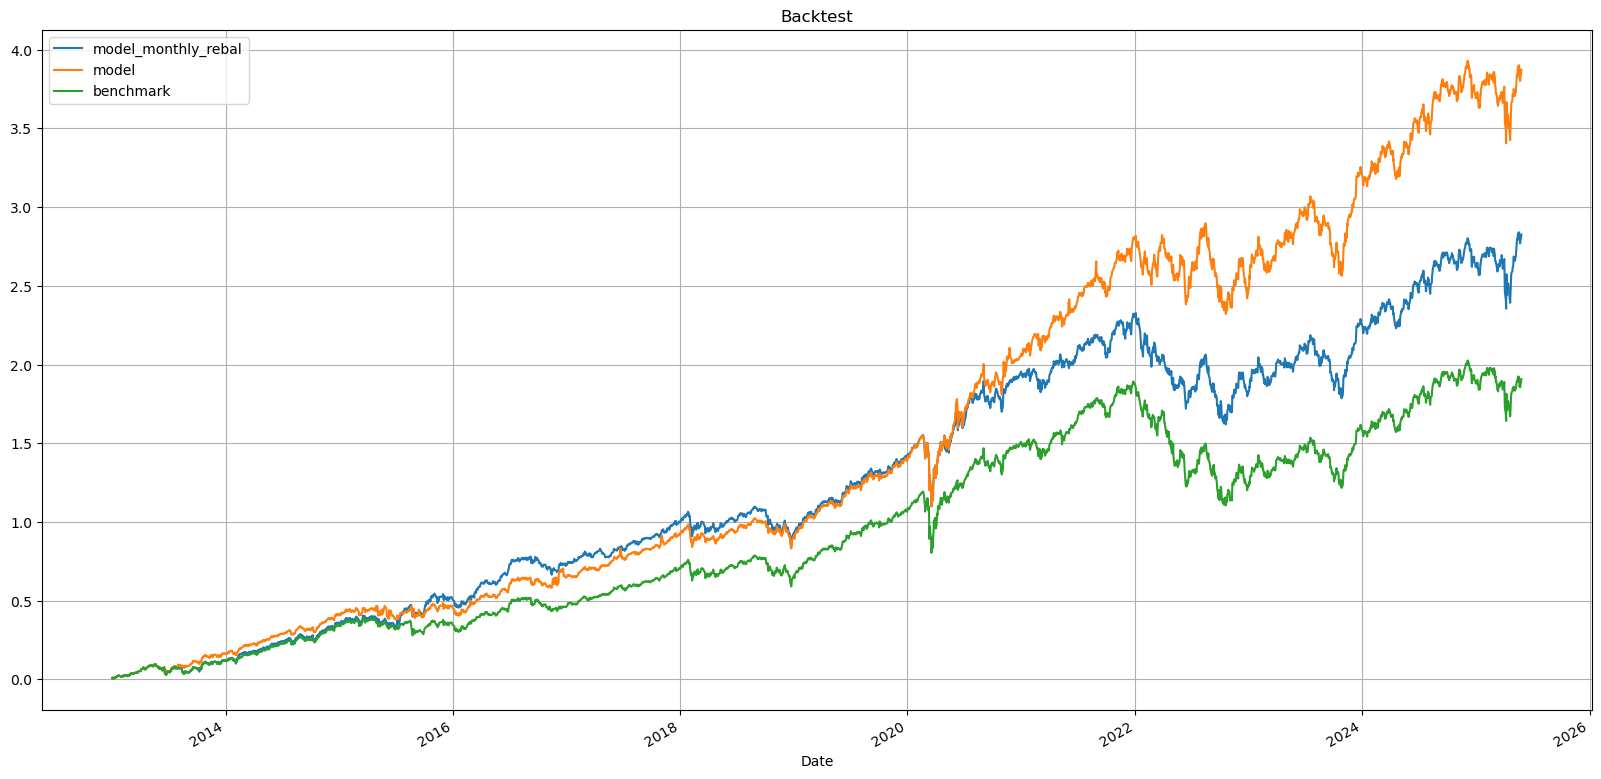

In [123]:
#((1+(wts_monthly_rebal*raw_rets)).cumprod()-1).sum(axis = 1).plot(label = 'model_monthly_rebal',figsize = (20,10))
ret = (0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])+(wts.rolling(20).mean()*raw_rets-costs).sum(axis = 1)
ret_mthly = (0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])+(wts_monthly_rebal*raw_rets).sum(axis = 1)
((1+ret_mthly).cumprod()-1).plot(label = 'model_monthly_rebal',figsize = (20,10))
model_alpha = ((1+ret).cumprod()-1)
model_alpha.plot(label = 'model',figsize = (20,10))
benchmark_alpha = ((1+(0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])).cumprod()-1)
benchmark_alpha.plot(label = 'benchmark',title = 'Backtest')
plt.legend()
plt.grid()

In [124]:
model_alpha_monthly = ((1+ret_mthly).cumprod()-1)
model_alpha_monthly

Date
2013-01-02    0.010030
2013-01-03    0.003187
2013-01-04    0.007396
2013-01-07    0.005914
2013-01-08    0.006827
                ...   
2025-05-20    2.838244
2025-05-21    2.787750
2025-05-22    2.783558
2025-05-23    2.770162
2025-05-27    2.825845
Length: 3119, dtype: float64

## <a id="7-plots"></a> 7. Plots


In [131]:
import plotly.graph_objects as go
import plotly.express as px

import plotly.graph_objects as go


import matplotlib.pyplot as plt

def plot_cumulative_returns(cumulative_returns: pd.Series, 
                            benchmark_returns: pd.Series,
                            label='Portfolio', 
                            benchmark_label='Benchmark'):
    plt.figure(figsize=(12, 6))
    
    # Plot both lines
    plt.plot(cumulative_returns, label=label, linewidth=2, color='tab:blue')
    plt.plot(benchmark_returns, label=benchmark_label, linestyle='--', linewidth=2, color='tab:orange')
    
    # Annotate last values
    last_date = cumulative_returns.index[-1]
    plt.text(last_date, cumulative_returns.iloc[-1], 
             f'{label}: {cumulative_returns.iloc[-1]:.2f}', 
             fontsize=10, color='tab:blue', verticalalignment='bottom', horizontalalignment='right')

    last_benchmark_date = benchmark_returns.index[-1]
    plt.text(last_benchmark_date, benchmark_returns.iloc[-1], 
             f'{benchmark_label}: {benchmark_returns.iloc[-1]:.2f}', 
             fontsize=10, color='tab:orange', verticalalignment='bottom', horizontalalignment='right')

    # Formatting
    plt.title("Cumulative Returns vs Benchmark", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Growth of $1", fontsize=12)
    plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.4)
    plt.legend(loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()




def plot_drawdowns_interactive(cumulative_returns: pd.Series):
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max

    worst_date = drawdown.idxmin()
    worst_value = drawdown.min()

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=drawdown.index,
        y=drawdown,
        fill='tozeroy',
        mode='lines',
        name='Drawdown',
        line=dict(color='salmon')
    ))

    fig.add_trace(go.Scatter(
        x=[worst_date],
        y=[worst_value],
        mode='markers+text',
        marker=dict(color='red', size=8),
        text=[f"Worst: {worst_value:.2%}"],
        textposition="bottom right",
        name="Worst Drawdown"
    ))

    fig.update_layout(
        title="Drawdown",
        xaxis_title="Date",
        yaxis_title="Drawdown %",
        hovermode="x unified",
        template="plotly_white",
        width=850,
        height=500
    )

    fig.show()



def plot_rolling_sharpe_interactive(cumulative_returns: pd.Series, window=21):
    returns = cumulative_returns.pct_change().dropna()
    rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std()

    max_idx = rolling_sharpe.idxmax()
    min_idx = rolling_sharpe.idxmin()
    max_val = rolling_sharpe.max()
    min_val = rolling_sharpe.min()

    fig = go.Figure()

    # Rolling Sharpe line
    fig.add_trace(go.Scatter(
        x=rolling_sharpe.index,
        y=rolling_sharpe,
        mode='lines',
        name='Sharpe',
        line=dict(color='mediumblue')
    ))

    # Max point
    fig.add_trace(go.Scatter(
        x=[max_idx],
        y=[max_val],
        mode='markers+text',
        marker=dict(color='green', size=10),
        text=[f"Max: {max_val:.2f}"],
        textposition="top center",
        textfont=dict(size=14),
        name='Max Sharpe'
    ))

    # Min point
    fig.add_trace(go.Scatter(
        x=[min_idx],
        y=[min_val],
        mode='markers+text',
        marker=dict(color='red', size=10),
        text=[f"Min: {min_val:.2f}"],
        textposition="bottom center",
        textfont=dict(size=14),
        name='Min Sharpe'
    ))

    # Zero line
    fig.add_shape(
        type='line',
        x0=rolling_sharpe.index.min(),
        x1=rolling_sharpe.index.max(),
        y0=0,
        y1=0,
        line=dict(color='gray', width=1, dash='dash'),
        xref='x',
        yref='y'
    )

    fig.update_layout(
        title=f"{window}D Rolling Sharpe Ratio",
        xaxis_title="Date",
        yaxis_title="Sharpe Ratio",
        hovermode="x unified",
        template="plotly_white",
        width=1000,
        height=500
    )

    fig.show()



def plot_rolling_volatility_interactive(cumulative_returns: pd.Series, window=21):
    returns = cumulative_returns.pct_change().dropna()
    rolling_vol = returns.rolling(window).std()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=rolling_vol.index, y=rolling_vol, mode='lines', name='Volatility', line=dict(color='orange')))
    fig.update_layout(
        title=f"{window}D Rolling Volatility",
        xaxis_title="Date",
        yaxis_title="Volatility",
        hovermode="x unified",
        template="plotly_white"
    )
    fig.show()




def plot_capm_scatter_interactive(cumulative_returns: pd.Series, benchmark_cumulative: pd.Series):
    # Convert cumulative returns to daily/monthly returns
    port_rets = cumulative_returns.pct_change().dropna()
    bench_rets = benchmark_cumulative.pct_change().dropna()
    aligned_benchmark = bench_rets.loc[port_rets.index]

    # Run OLS regression
    X = sm.add_constant(aligned_benchmark)
    model = sm.OLS(port_rets, X).fit()
    alpha, beta = model.params

    # Prepare label for annotation
    annotation_text = f"Alpha: {alpha:.4f}<br>Beta: {beta:.4f}"

    # Scatter plot with regression line
    fig = px.scatter(
        x=aligned_benchmark,
        y=port_rets,
        trendline="ols",
        labels={"x": "Benchmark Returns", "y": "Portfolio Returns"},
        title="CAPM Regression: Portfolio vs. Benchmark",
        opacity=0.7
    )

    # Add annotation box
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.95, y=0.05,
        showarrow=False,
        align="right",
        bgcolor="white",
        bordercolor="black",
        borderwidth=1,
        text=annotation_text
    )

    # Style
    fig.update_traces(marker=dict(size=6, color='blue'))
    fig.update_layout(template="plotly_white")
    fig.show()

    return model

def plot_portfolio_weights(df_weights):
    """
    Plots stacked area chart of portfolio weights over time.
    
    Parameters:
    - df_weights: DataFrame with tickers as columns and dates as index
    """
    df = df_weights.dropna(how='all')
    plt.figure(figsize=(16, 6))
    df.plot(
        kind='area',
        stacked=True,
        colormap='tab20',
        alpha=0.9,
        linewidth=0.5
    )

    plt.title('Portfolio Weights Over Time', fontsize=16)
    plt.xlabel('Rebalance Date', fontsize=12)
    plt.ylabel('Weight', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title="Assets")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




def plot_capm_scatter_alpha(cumulative_returns: pd.Series,
                                  benchmark_cumulative: pd.Series,
                                  title: str = "Alpha vs 60/40 Benchmark"):

    port_rets  = cumulative_returns.pct_change().dropna()
    bench_rets = benchmark_cumulative.pct_change().dropna()

    # Align dates
    bench_rets = bench_rets.reindex(port_rets.index, method="ffill")

    alpha_rets = port_rets - bench_rets      # excess over 60/40 (alpha)

    # OLS
    X = sm.add_constant(bench_rets)
    model = sm.OLS(alpha_rets, X).fit()
    jensen_alpha, beta = model.params

    annotation = f"Jensen α (intercept): {jensen_alpha:.4%}<br>Beta: {beta:.4f}"

    #Scatter with regression line
    fig = px.scatter(
        x=bench_rets,
        y=alpha_rets,
        trendline="ols",
        labels={"x": "Benchmark Period Return", "y": "Alpha Period Return"},
        title=title,
        opacity=0.75
    )

    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.95, y=0.05,
        showarrow=False,
        bgcolor="white",
        bordercolor="black",
        borderwidth=1,
        align="right",
        text=annotation
    )

    fig.update_traces(marker=dict(size=6, color="darkblue"))
    fig.update_layout(template="plotly_white")
    fig.show()

    return model




### <a id="7-1-alpha-model-performance-plots"></a> 7.1. Alpha Model Portfolio Performance Plots


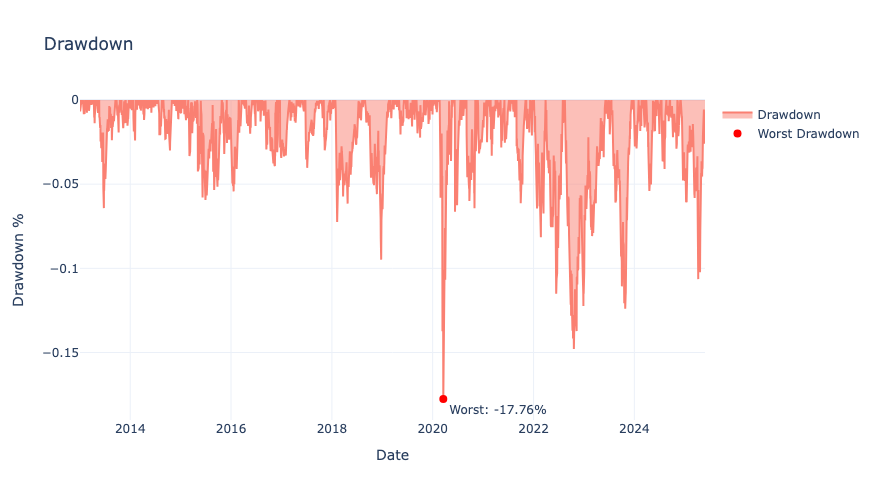

In [136]:
model_alpha_val = (1 + model_alpha)
plot_drawdowns_interactive(model_alpha_val)


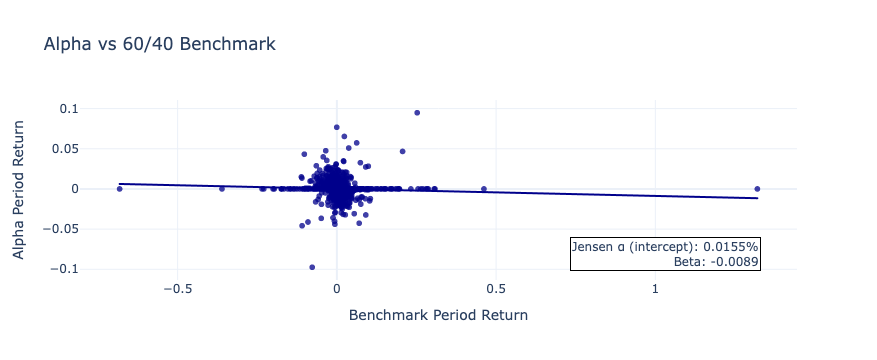

In [138]:
plot_capm_scatter_alpha(model_alpha_monthly, benchmark_alpha, "Alpha vs 60/40 Benchmark")

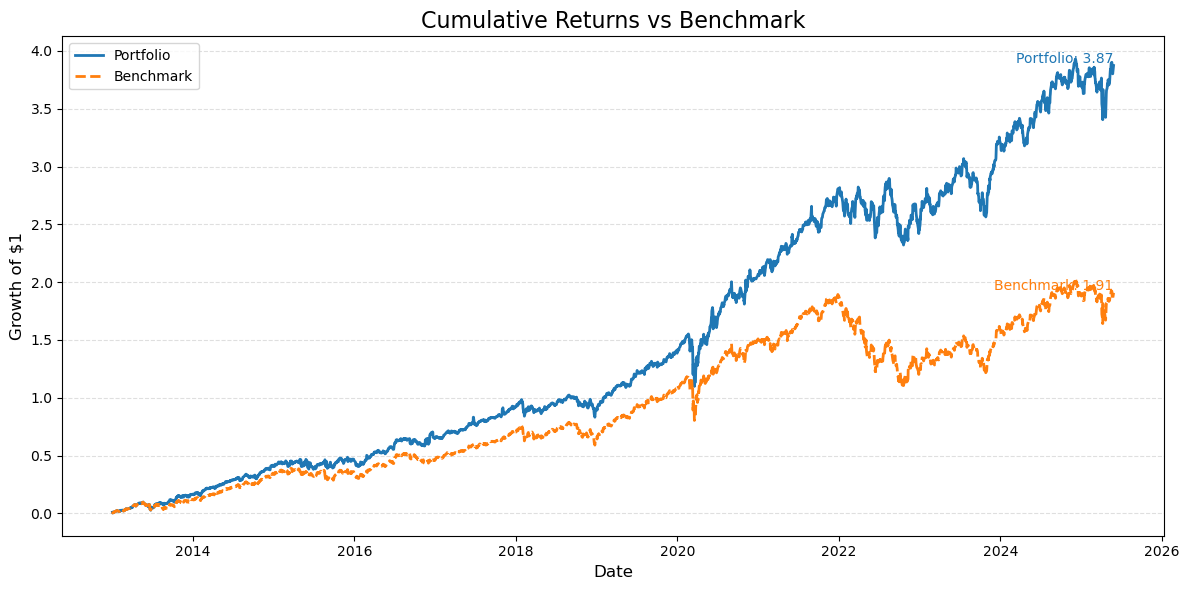

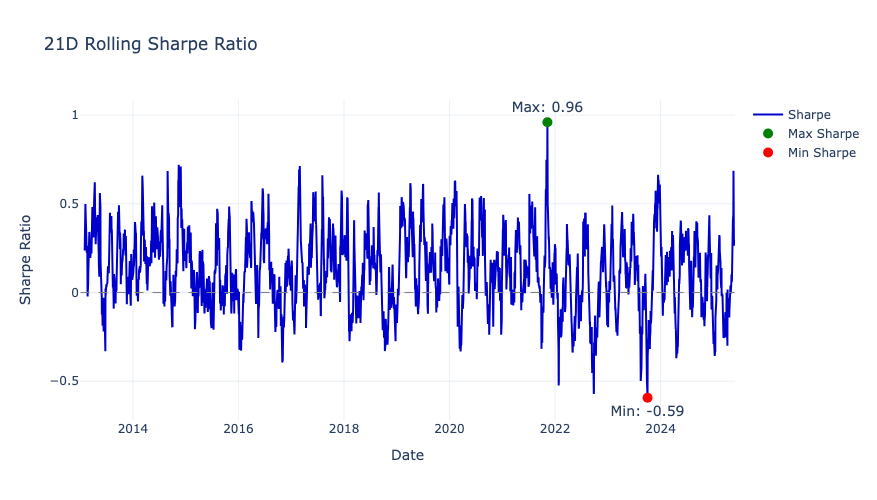

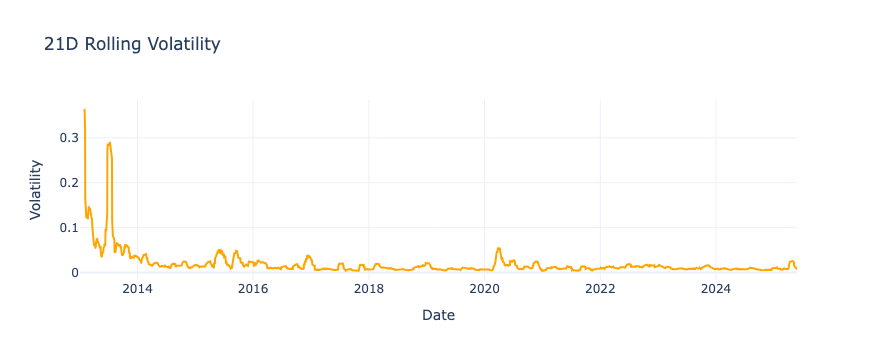

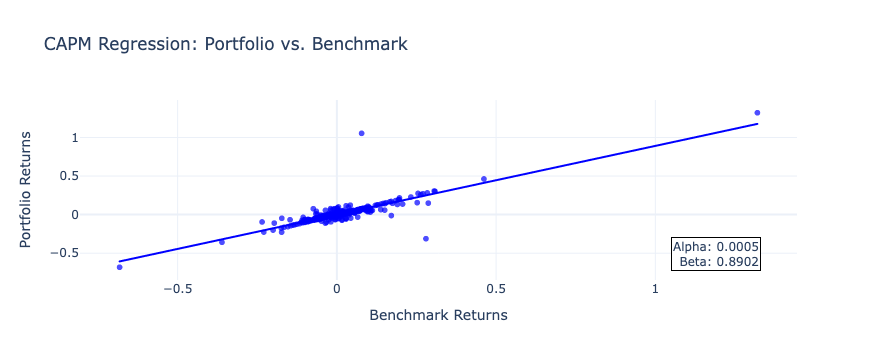

In [140]:
plot_cumulative_returns(model_alpha, benchmark_alpha, label="Portfolio", benchmark_label="Benchmark")

plot_rolling_sharpe_interactive(model_alpha)
plot_rolling_volatility_interactive(model_alpha)

plot_capm_scatter_interactive(model_alpha, benchmark_alpha)
# plot_portfolio_weights(wts_linear.resample('M').last())


## <a id="8-alpha-model-performance-attribution"></a> 8. Alpha Model Performance Attribution


In [143]:
final_pred2 = final_pred.mean(axis=1)
featuresandpred = pd.concat([final_pred2, merged.iloc[:-3]], axis=1)
regimecols = ['PredLabel_Goldilocks', 'PredLabel_Slow Growth', 'PredLabel_Stagflation', 'PredLabel_Heating Up']

regime1 = featuresandpred[featuresandpred['PredLabel_Goldilocks'] == 1].drop(regimecols, axis=1)
regime2 = featuresandpred[featuresandpred['PredLabel_Slow Growth'] == 1].drop(regimecols, axis=1)
regime3 = featuresandpred[featuresandpred['PredLabel_Stagflation'] == 1].drop(regimecols, axis=1)
regime4 = featuresandpred[featuresandpred['PredLabel_Heating Up'] == 1].drop(regimecols, axis=1)

regime1returns = regime1[[0]]
regime2returns = regime2[[0]]
regime3returns = regime3[[0]]
regime4returns = regime4[[0]]

regime1.drop(0, axis=1, inplace=True)
regime2.drop(0, axis=1, inplace=True)
regime3.drop(0, axis=1, inplace=True)
regime4.drop(0, axis=1, inplace=True)







In [145]:


def barplot_and_pval_table(result, title="Factor Betas (OLS)"):

    betas = result.params.drop('const', errors='ignore')
    pvals = result.pvalues.drop('const', errors='ignore')

    def star(p):
        return "Very Strong Evidence" if p < 0.01 else "Strong Evidence" if p < 0.05 else "Weak Evidence" if p < 0.10 else "Weak Evidence"

    table = (pd.DataFrame({"Beta": betas, "p-value": pvals})
               .assign(Sig=lambda df: df["p-value"].apply(star))
               .sort_values("Beta"))

    print("\nCoefficient Table")
    print(table.round({"Beta": 4, "p-value": 4}))

    plt.figure(figsize=(8, 4))
    plt.barh(table.index, table["Beta"], color="skyblue")
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Beta")

    # Annotate each bar with its beta value
    for y, beta in enumerate(table["Beta"]):
        plt.text(beta, y, f"  {beta:.4f}", va='center',
                 ha="left" if beta >= 0 else "right")

    plt.tight_layout()
    plt.show()





### <a id="8-1-goldilocks-regime"></a> 8.1. Goldilocks Regime



Coefficient Table
                      Beta  p-value                   Sig
RF                 -0.0103   0.0000  Very Strong Evidence
REAINTRATREARAT10Y -0.0012   0.0992         Weak Evidence
SMB                -0.0004   0.0000  Very Strong Evidence
HML                 0.0001   0.3728         Weak Evidence
MEDCPIM158SFRBCLE   0.0001   0.6018         Weak Evidence
RMW                 0.0002   0.0912         Weak Evidence
CMA                 0.0003   0.0075  Very Strong Evidence
Mkt-RF              0.0004   0.0000  Very Strong Evidence
UNRATE              0.0008   0.0468       Strong Evidence


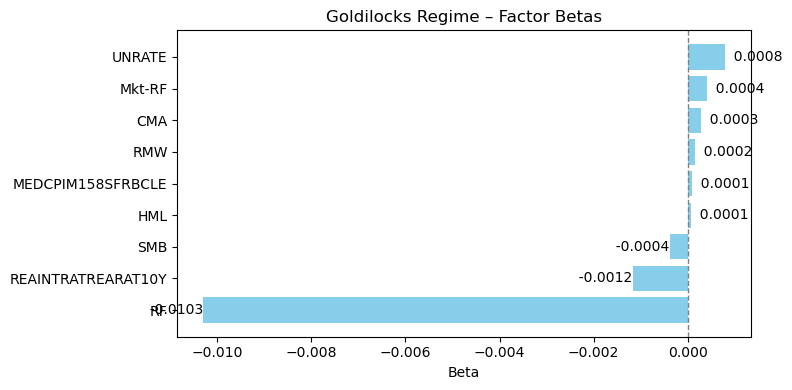

In [148]:
res_gold = sm.OLS(regime1returns, regime1).fit()
barplot_and_pval_table(res_gold, "Goldilocks Regime – Factor Betas")

### <a id="8-2-slow-growth-regime"></a> 8.2. Slow Growth Regime



Coefficient Table
                      Beta  p-value                   Sig
UNRATE             -0.0694   0.0000  Very Strong Evidence
SMB                -0.0008   0.0000  Very Strong Evidence
HML                -0.0005   0.0319       Strong Evidence
RMW                -0.0004   0.0707         Weak Evidence
Mkt-RF              0.0004   0.0000  Very Strong Evidence
CMA                 0.0012   0.0000  Very Strong Evidence
MEDCPIM158SFRBCLE   0.0045   0.0000  Very Strong Evidence
REAINTRATREARAT10Y  0.0163   0.0000  Very Strong Evidence
RF                  0.0494   0.0000  Very Strong Evidence


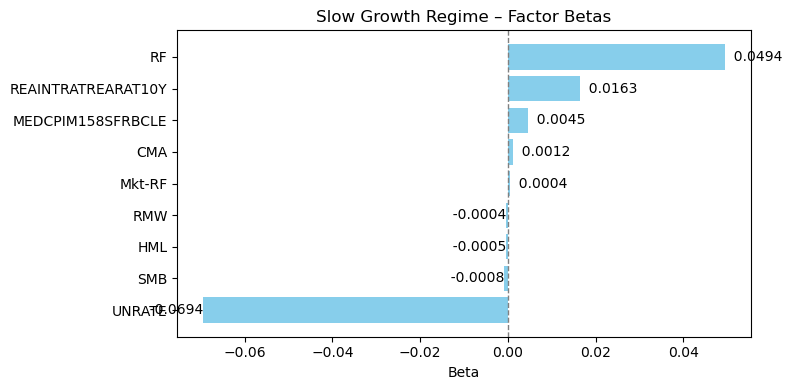

In [151]:
res_slow = sm.OLS(regime2returns, regime2).fit()
barplot_and_pval_table(res_slow, "Slow Growth Regime – Factor Betas")

### <a id="8-3-stagflation-regime"></a> 8.3. Stagflation Regime



Coefficient Table
                      Beta  p-value                   Sig
RF                 -0.0211   0.0000  Very Strong Evidence
RMW                -0.0009   0.0000  Very Strong Evidence
SMB                -0.0006   0.0000  Very Strong Evidence
HML                -0.0005   0.0000  Very Strong Evidence
UNRATE             -0.0004   0.8330         Weak Evidence
Mkt-RF              0.0002   0.0025  Very Strong Evidence
CMA                 0.0021   0.0000  Very Strong Evidence
MEDCPIM158SFRBCLE   0.0024   0.0000  Very Strong Evidence
REAINTRATREARAT10Y  0.0080   0.0000  Very Strong Evidence


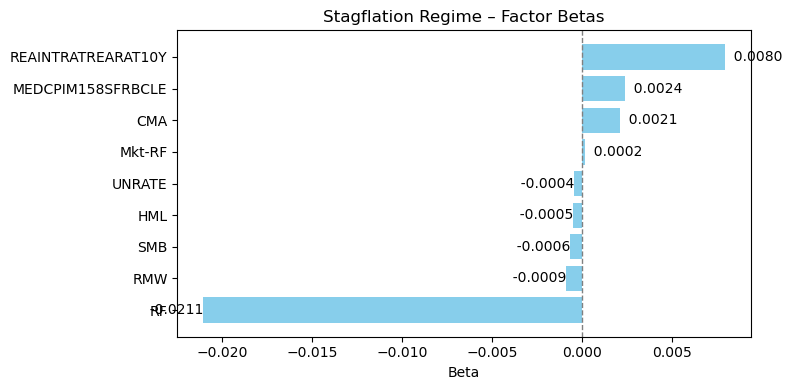

In [154]:
res_stag = sm.OLS(regime3returns, regime3).fit()
barplot_and_pval_table(res_stag, "Stagflation Regime – Factor Betas")

### <a id="8-4-heating-up-regime"></a> 8.4. Heating Up Regime



Coefficient Table
                      Beta  p-value                   Sig
RF                 -0.0168   0.0000  Very Strong Evidence
REAINTRATREARAT10Y -0.0048   0.0089  Very Strong Evidence
RMW                -0.0013   0.0000  Very Strong Evidence
MEDCPIM158SFRBCLE  -0.0011   0.0306       Strong Evidence
SMB                -0.0008   0.0000  Very Strong Evidence
CMA                -0.0007   0.0003  Very Strong Evidence
UNRATE             -0.0003   0.6380         Weak Evidence
Mkt-RF              0.0002   0.0000  Very Strong Evidence
HML                 0.0009   0.0000  Very Strong Evidence


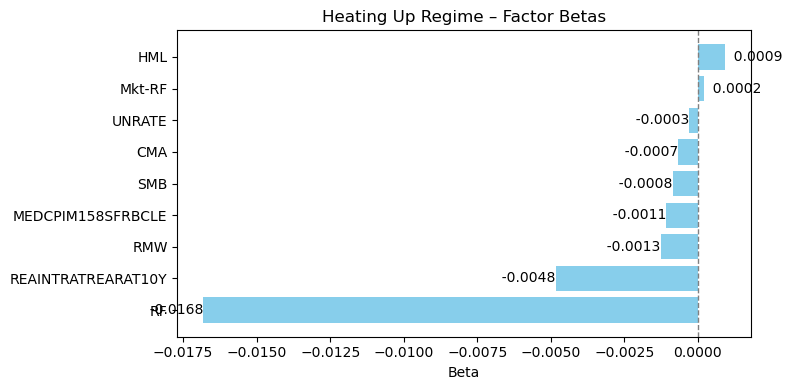

In [157]:
res_heat = sm.OLS(regime4returns, regime4).fit()
barplot_and_pval_table(res_heat, "Heating Up Regime – Factor Betas")

## Linear Model Portfolio Plots

In [209]:
# # plot_cumulative_returns(model_monthly_rebal_linear, benchmark_linear, label="Portfolio", benchmark_label="Benchmark")
# plot_cumulative_returns(model_linear, benchmark_linear, label="Portfolio", benchmark_label="Benchmark")

# plot_drawdowns_interactive(model_linear)
# plot_rolling_sharpe_interactive(model_linear)
# plot_rolling_volatility_interactive(model_linear)

# plot_capm_scatter_interactive(model_linear, benchmark_linear)
# plot_portfolio_weights(wts_linear.resample('M').last())
# reg_model = run_performance_attribution(
#     cum_returns=model_linear,
#     benchmark_cum_returns=benchmark_linear,
#     merged_factors=merged,
#     label="Linear Model"
# )


## Elastic Net Model Portfolio Plots

In [211]:
# plot_drawdowns_interactive(model_enet)
# plot_rolling_sharpe_interactive(model_enet)
# plot_rolling_volatility_interactive(model_enet)

# plot_capm_scatter_interactive(model_enet, benchmark_enet)
# plot_portfolio_weights(wts_enet.resample('M').last())
# run_performance_attribution(
#     cum_returns=model_enet,
#     benchmark_cum_returns=benchmark_enet,
#     merged_factors=merged,
#     label="Elastic Net"
# )

## XGB Model Portfolio Plots

In [213]:
# plot_cumulative_returns(model_monthly_rebal_xgb, benchmark_xgb, label="XGB Model", benchmark_label="Benchmark")

# plot_drawdowns_interactive(model_xgb)
# plot_rolling_sharpe_interactive(model_xgb)
# plot_rolling_volatility_interactive(model_xgb)

# plot_capm_scatter_interactive(model_xgb, benchmark_xgb)
# plot_portfolio_weights(wts_xgb.resample('M').last())
# run_performance_attribution(
#     cum_returns=model_xgb,
#     benchmark_cum_returns=benchmark_xgb,
#     merged_factors=merged,
#     label="XGBoost Model"
# )